In [1]:
!pip install opendatasets pillow matplotlib seaborn scikit-learn
!pip install opendatasets kaggle
!pip install tensorflow

In [2]:
# Import library yang diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import opendatasets as od
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import to_categorical
import warnings
from google.colab import files
import pickle
import pandas as pd

warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Set matplotlib style
plt.style.use('ggplot')

In [5]:
# DOWNLOAD DATASET
dataset_url = "https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset"
od.download(dataset_url)

# Verifikasi path
dataset_path = "/content/mango-leaf-disease-dataset"
print("Isi folder dataset:")
print(os.listdir(dataset_path))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: permataa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset


100%|██████████| 103M/103M [00:00<00:00, 1.29GB/s]

Isi folder dataset:
['Cutting Weevil', 'Anthracnose', 'Healthy', 'Gall Midge', 'Die Back', 'Sooty Mould', 'Bacterial Canker', 'Powdery Mildew']


In [6]:
# Daftar kelas
class_names = sorted(['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back',
                     'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould'])

In [7]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

print(class_counts)

{'Anthracnose': 500, 'Bacterial Canker': 500, 'Cutting Weevil': 500, 'Die Back': 500, 'Gall Midge': 500, 'Healthy': 500, 'Powdery Mildew': 500, 'Sooty Mould': 500}


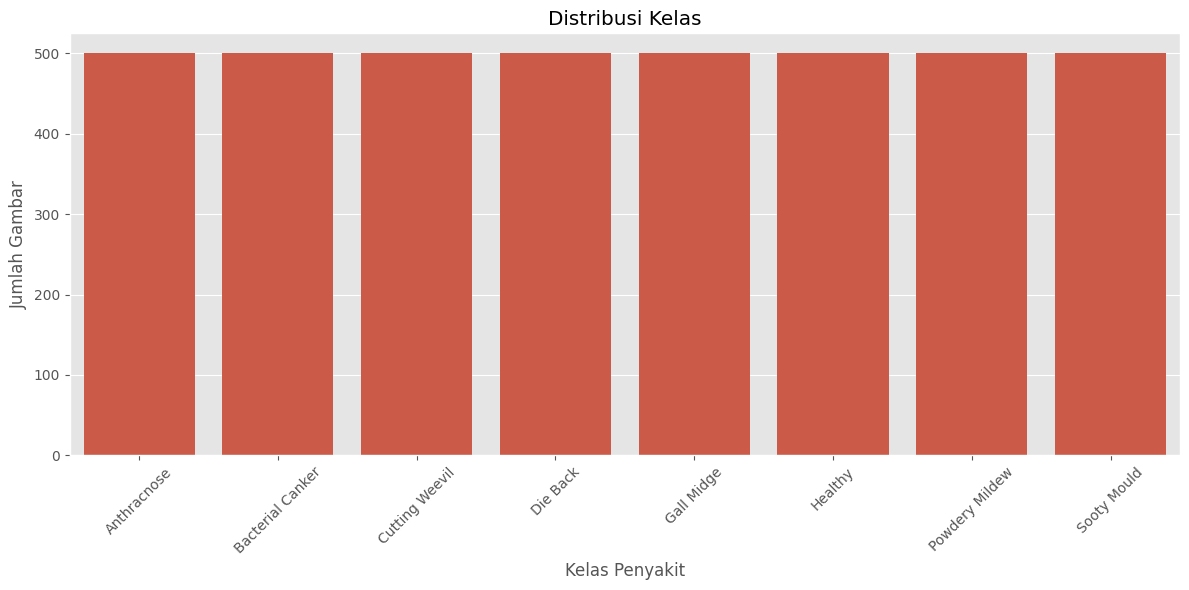

In [8]:
# Plot distribusi kelas
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Distribusi Kelas")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas Penyakit")
plt.tight_layout()
plt.show()

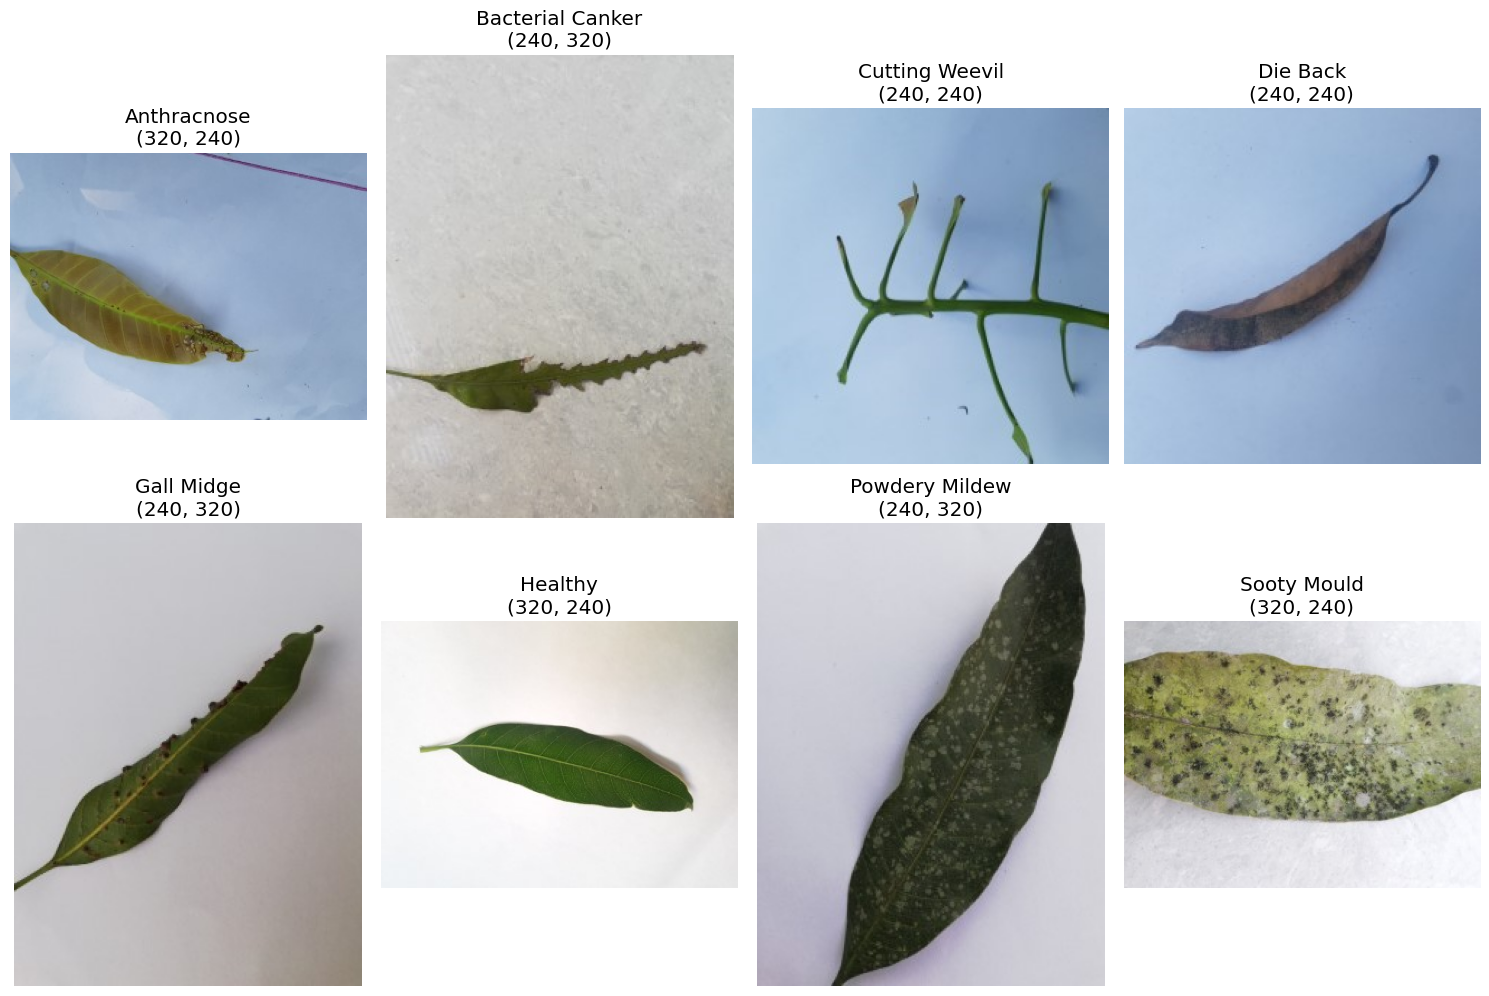

In [9]:
# Contoh gambar per kelas
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    img_path = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
    img = Image.open(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"{class_name}\n{img.size}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Persiapan data
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

In [11]:
# Buat dataframe untuk gambar dan label
data = []
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append({'filename': img_path, 'label': class_name})

df = pd.DataFrame(data)

In [12]:
# Split data menjadi 80% training, 10% validation, dan 10% testing
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 3200
Validation samples: 400
Testing samples: 400


In [13]:
# Buat generator data tanpa augmentasi
train_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
val_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [16]:
# Gunakan EfficientNetB4 sebagai base model
def create_model(num_classes):
    base_model = EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_model(num_classes=len(class_names))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,887 (69.18 MB)

 Trainable params: 461,064 (1.76 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7721 - loss: 0.6828

100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 372ms/step - accuracy: 0.7733 - loss: 0.6794 - val_accuracy: 0.9850 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9639 - loss: 0.1167

100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.9640 - loss: 0.1164 - val_accuracy: 0.9900 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9784 - loss: 0.0716

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9784 - loss: 0.0716 - val_accuracy: 0.9975 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9867 - loss: 0.0443 - val_accuracy: 0.9975 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9921 - loss: 0.0299 - val_accuracy: 0.9975 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9906 - loss: 0.0278 - val_accuracy: 0.9950 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9902 - loss: 0.0276 - val_accuracy: 0.9925 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9942 - loss: 0.0182

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 1.0000 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9958 - loss: 0.0157 - val_accuracy: 0.9975 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9932 - loss: 0.0225 - val_accuracy: 0.9950 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9954 - loss: 0.0138 - val_accuracy: 0.9900 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.9984 - loss: 0.0105 - val_accuracy: 0.9975 - val_loss: 0.0053 - learning_rate: 2.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9971 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0032 - learning_rate: 2.0000e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0

In [18]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0031
Test accuracy: 100.00%


In [19]:
# Prediksi pada test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 934ms/step
Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      1.00      1.00        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       1.00      1.00      1.00        50
     Sooty Mould       1.00      1.00      1.00        50

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400



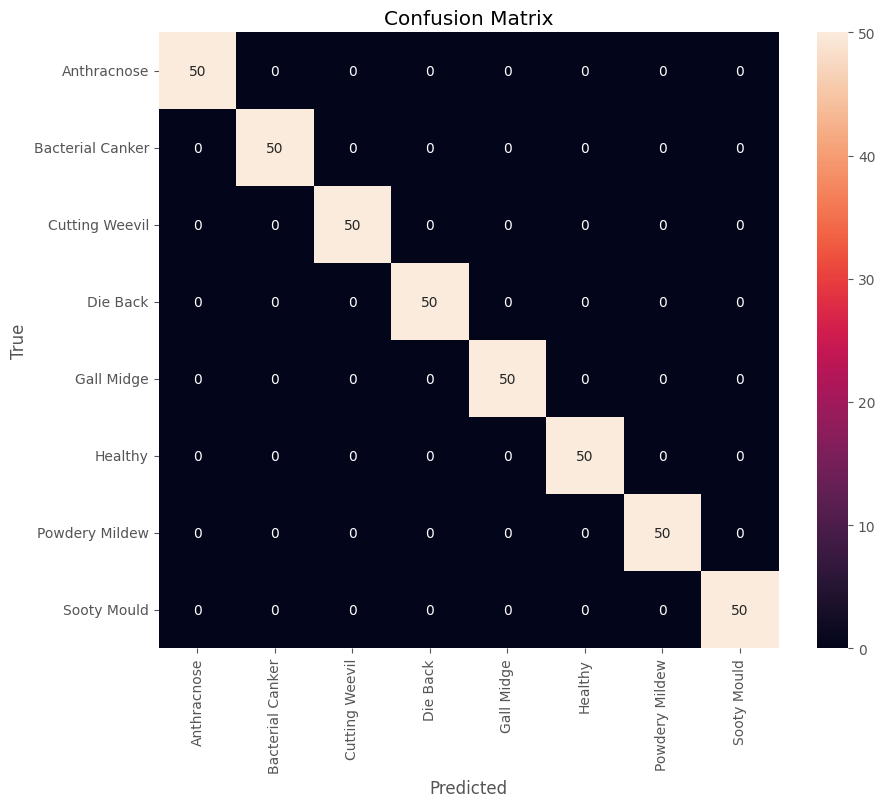

In [20]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

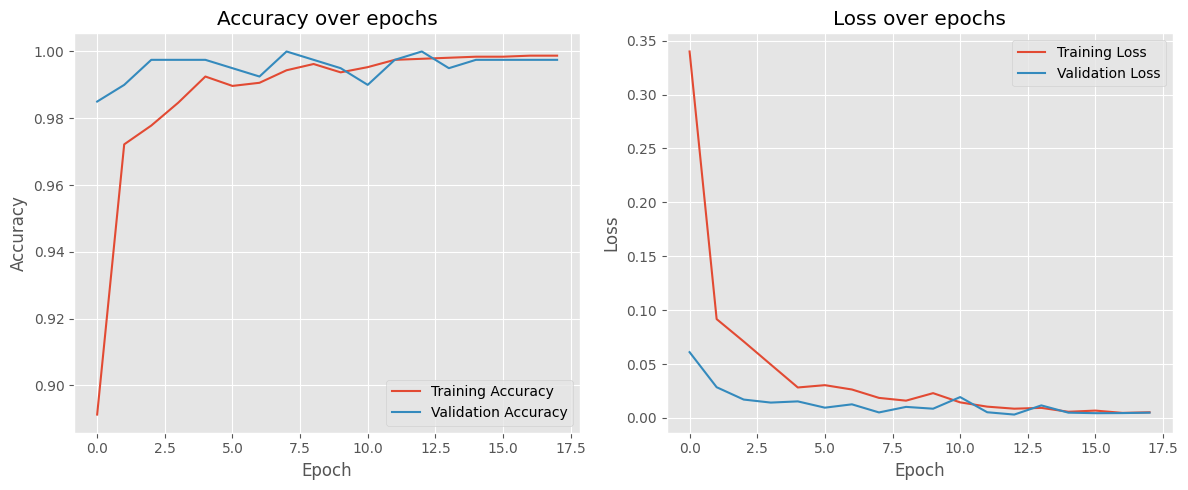

In [23]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Simpan model ke format HDF5 (.h5)
model.save("mangalyze_model.h5")

In [25]:
# Simpan model menggunakan pickle
with open("mangalyze_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [26]:
model.save("mangalyze_model.keras")

In [27]:
files.download('mangalyze_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
files.download('mangalyze_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
files.download('mangalyze_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>